Install Required Dependencies

In [ ]:
!pip install fastai
!pip install -q kaggle
!mkdir -p ~/.kaggle

Importing the required modules

In [5]:
import os
from fastai.vision.all import *
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
os.environ['KAGGLE_USERNAME'] = 'zuhairmalik'
os.environ['KAGGLE_KEY'] = '1e035b7e15136'

In [7]:
api = KaggleApi()
api.authenticate()

Downloading the dataset

In [8]:
api.dataset_download_files('feyzazkefe/trashnet', path='./data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/feyzazkefe/trashnet


Sorting the classes into recyclable and non recyclable

In [9]:
recyclable = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
non_recyclable = ['trash']

In [10]:
def is_recyclable(file_path):
    category = file_path.parent.name
    return 'recyclable' if category in recyclable else 'non_recyclable'

In [11]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=is_recyclable,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
)

In [12]:
dls = dblock.dataloaders('./data', bs=64)

Using the Resnet Model

In [13]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/zuhair/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:11<00:00, 7.54MB/s]


Fine Tuning over 5 Epochs (Make sure to enable GPU runtime type to avoid long processing times)

In [14]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.039219,0.490620,0.213861,0.786139,00:09


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.662948,0.394683,0.156436,0.843564,00:10
1,0.513019,0.368289,0.150495,0.849505,00:10
2,0.385343,0.218423,0.073267,0.926733,00:10
3,0.291003,0.159470,0.041584,0.958416,00:10
4,0.226215,0.138389,0.041584,0.958416,00:10


Getting Predictions

In [15]:
preds, targets = learn.get_preds()

Visualising Some Results

<Figure size 1000x800 with 0 Axes>

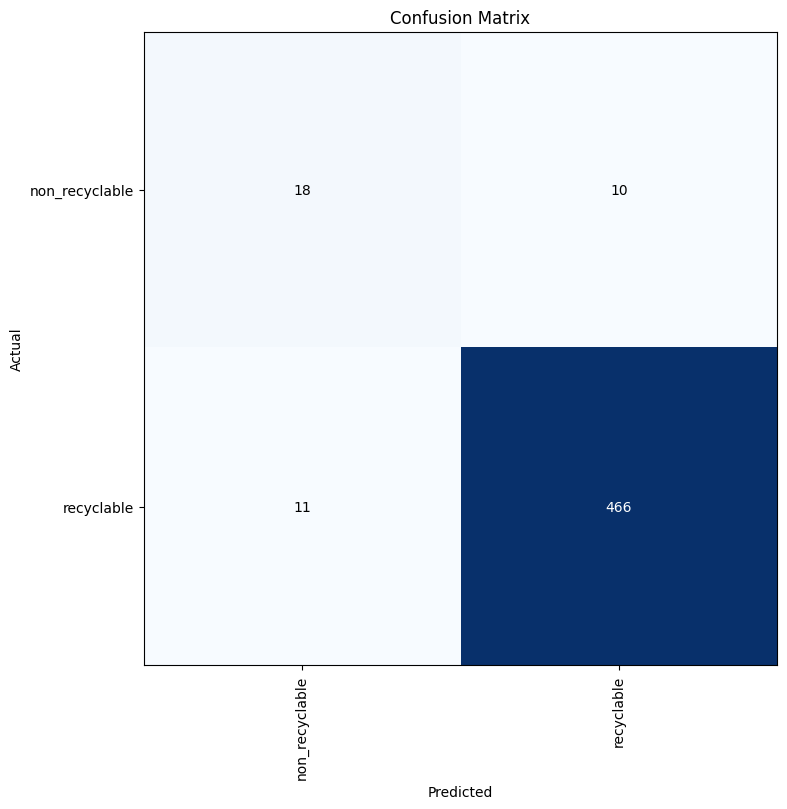

In [16]:
plt.figure(figsize=(10, 8))
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 8))
plt.title('Confusion Matrix')
plt.show()

In [17]:
pred_classes = preds.argmax(dim=1)
target_names = learn.dls.vocab
print(classification_report(targets, pred_classes, target_names=target_names))

                precision    recall  f1-score   support

non_recyclable       0.62      0.64      0.63        28
    recyclable       0.98      0.98      0.98       477

      accuracy                           0.96       505
     macro avg       0.80      0.81      0.80       505
  weighted avg       0.96      0.96      0.96       505



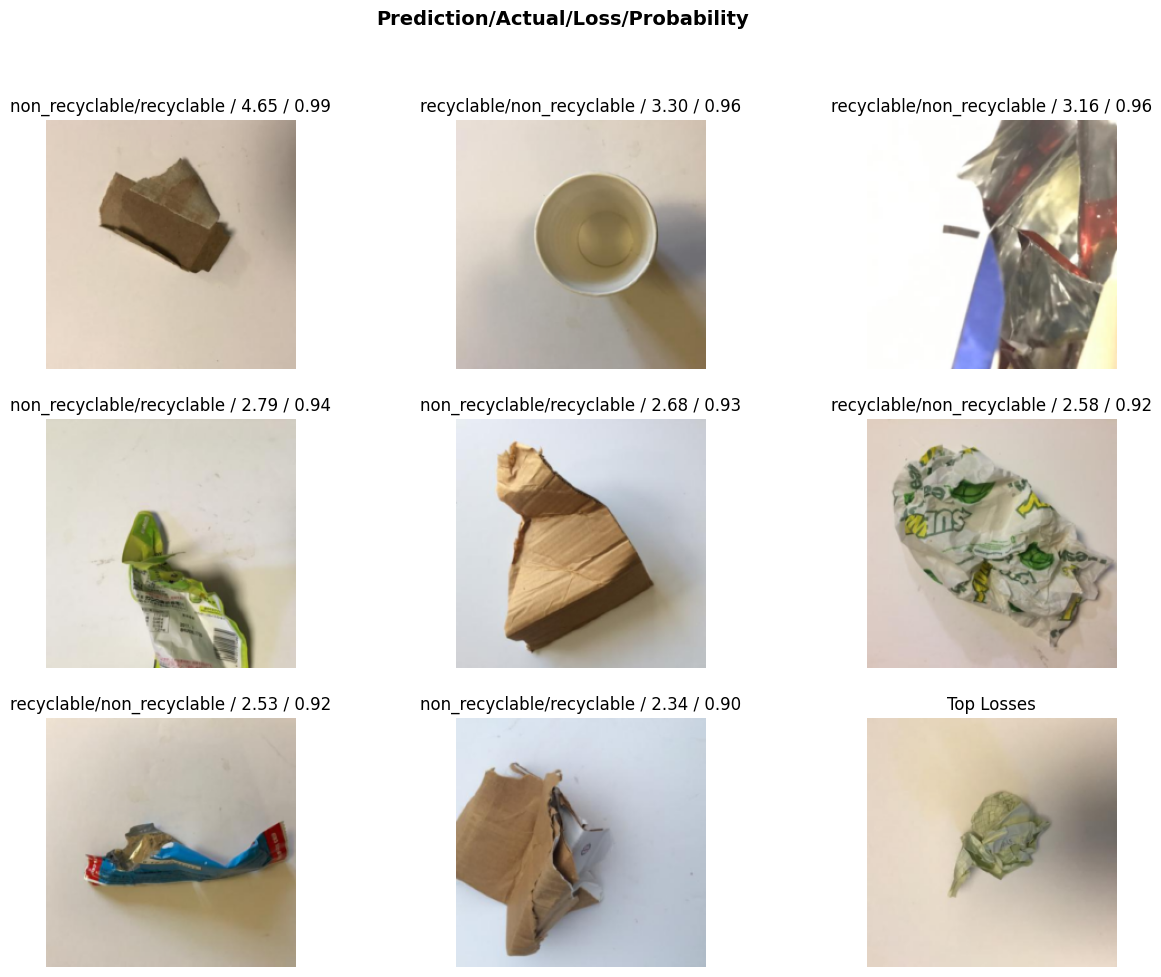

In [18]:
interp.plot_top_losses(9, figsize=(15, 11))
plt.title('Top Losses')
plt.show()

/home/zuhair/.local/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_lo

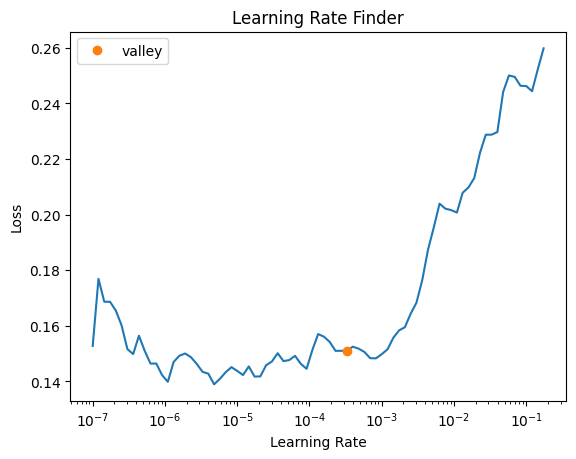

In [19]:
learn.lr_find()
plt.title('Learning Rate Finder')
plt.show()

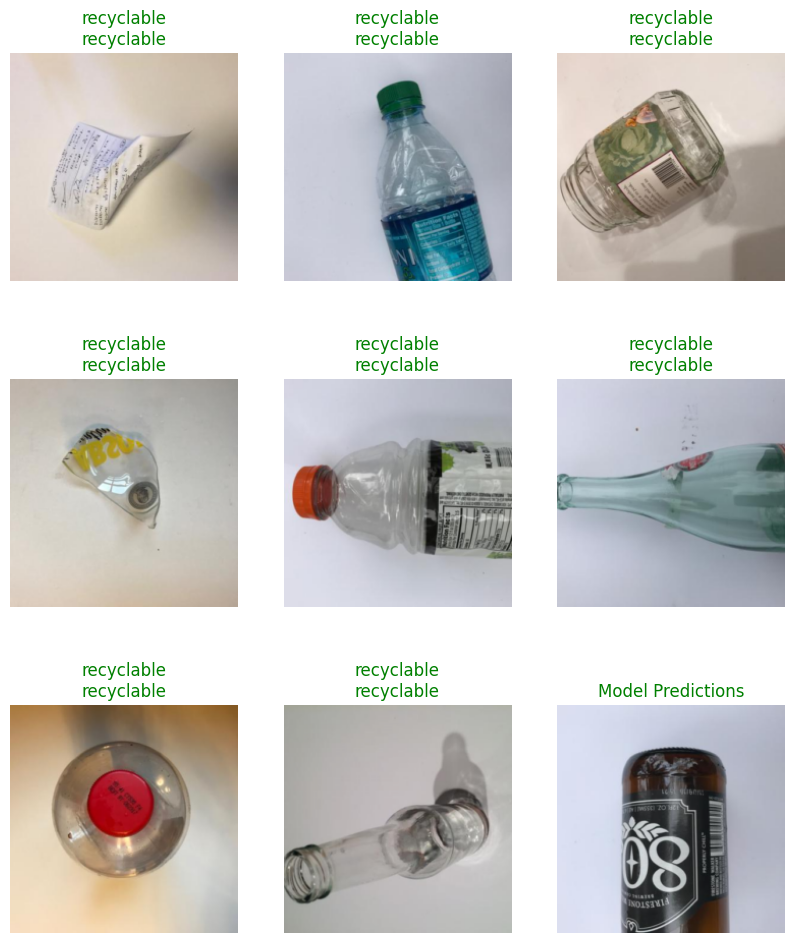

In [20]:
learn.show_results(ds_idx=1, nrows=3, figsize=(10, 12))
plt.title('Model Predictions')
plt.show()

In [21]:
def accuracy_per_class(interp):
    cm = interp.confusion_matrix()
    acc_dict = {}
    for i, class_name in enumerate(interp.vocab):
        acc_dict[class_name] = cm[i][i] / cm[i].sum()
    return acc_dict

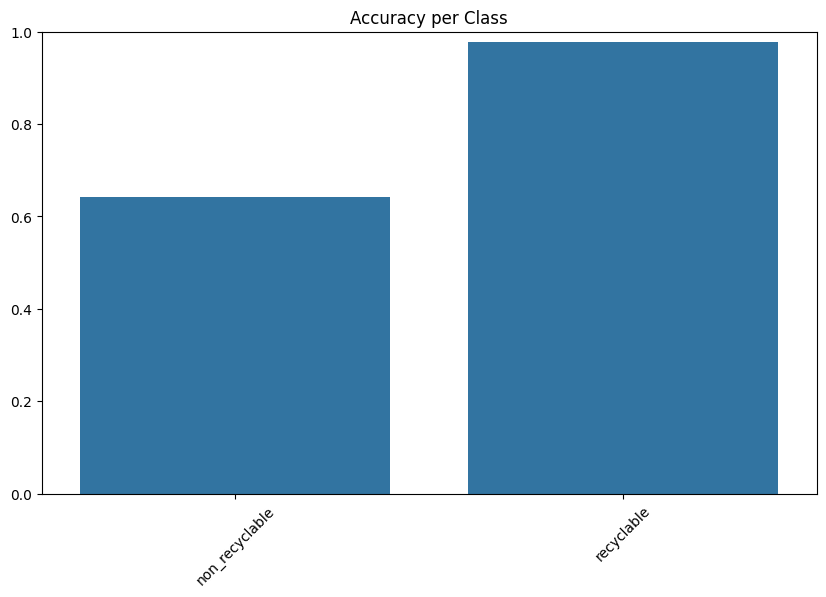

In [22]:
acc_per_class = accuracy_per_class(interp)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(acc_per_class.keys()), y=list(acc_per_class.values()))
plt.title('Accuracy per Class')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

In [23]:
img = PILImage.create('./data/dataset-resized/paper/paper1.jpg')
pred_class, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred_class}")
print(f"Probability: {probs[pred_idx]:.4f}")

Prediction: recyclable
Probability: 0.9743


Predicted: recyclable


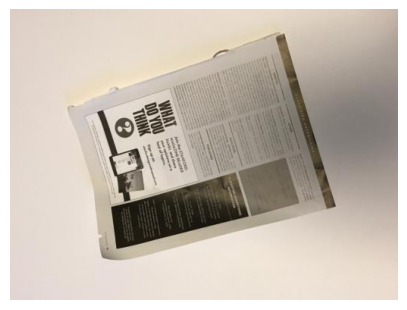

In [24]:
img.show()
print(f"Predicted: {pred_class}")

Save the model

In [25]:
learn.save('trashnet_model')
learn.export()